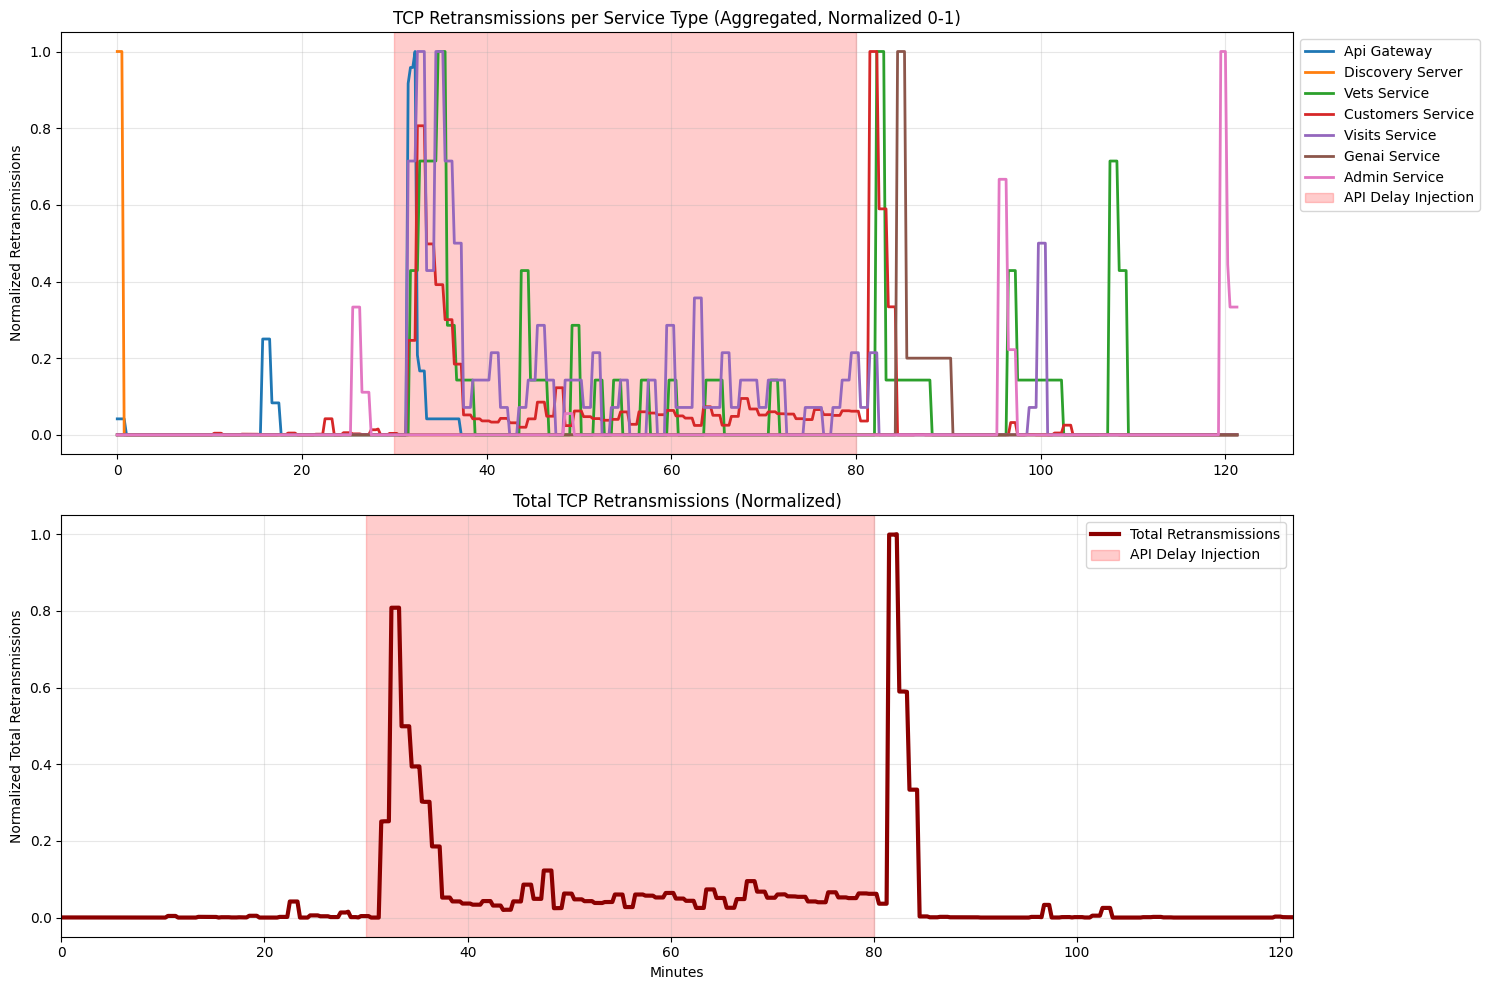

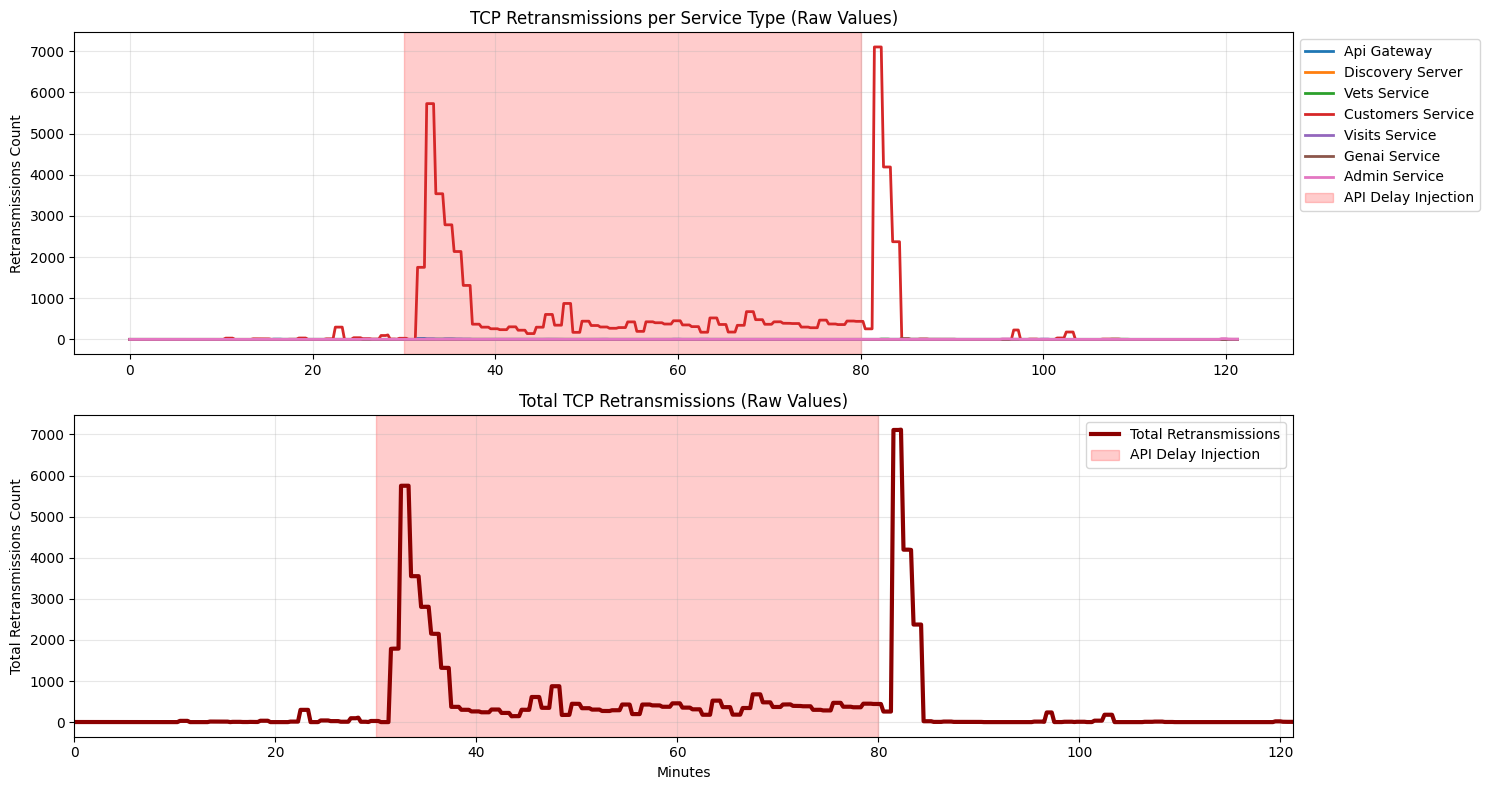

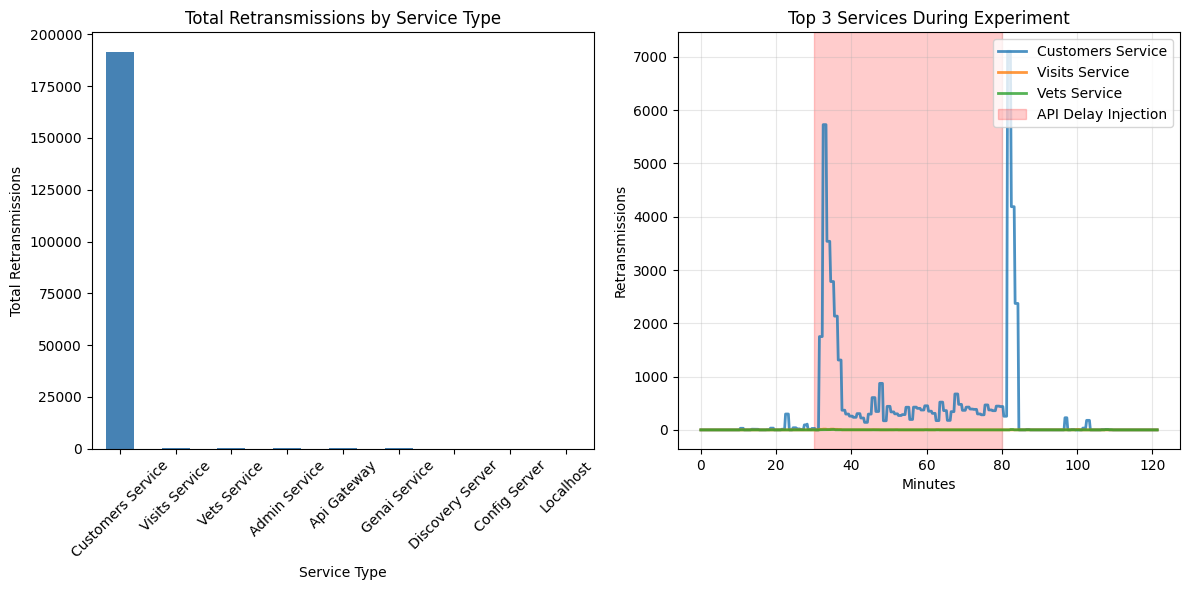

=== TCP Retransmissions Summary (Aggregated by Service Type) ===
Total experiment duration: 121.2 minutes
Total retransmissions: 192709.0
Peak retransmissions: 7116.0
Average retransmissions per minute: 396.52

=== Service Type Breakdown ===
Customers Service: 191384.0 retransmissions
Visits Service: 552.0 retransmissions
Vets Service: 264.0 retransmissions
Admin Service: 186.0 retransmissions
Api Gateway: 160.0 retransmissions
Genai Service: 160.0 retransmissions
Discovery Server: 3.0 retransmissions

=== Impact Analysis ===
Baseline average retransmissions: 20.01
During delay average retransmissions: 656.92
Increase factor: 32.83x

=== Per-Service Impact During Delay ===
Api Gateway: 2.06x increase
Discovery Server: 0.00x increase
Vets Service: 0.76 (from 0 baseline)
Customers Service: 33.63x increase
Visits Service: 2.49 (from 0 baseline)
Genai Service: 0.00 (from 0 baseline)
Admin Service: 0.07x increase


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the TCP retransmission data
df_tcp_retrans = pd.read_csv("retrans_packets.csv")

# Convert Time to datetime
df_tcp_retrans["Time"] = pd.to_datetime(df_tcp_retrans["Time"])

# Create minutes column for plotting
df_tcp_retrans["Minutes"] = (df_tcp_retrans["Time"] - df_tcp_retrans["Time"].min()).dt.total_seconds() / 60

# Group columns by service type (ignoring role/instance differences)
service_groups = {
   'api_gateway': [col for col in df_tcp_retrans.columns if 'api_gateway' in col],
   'discovery_server': [col for col in df_tcp_retrans.columns if 'discovery_server' in col],
   'config_server': [col for col in df_tcp_retrans.columns if 'config_server' in col],
   'vets_service': [col for col in df_tcp_retrans.columns if 'vets' in col],
   'customers_service': [col for col in df_tcp_retrans.columns if 'customers' in col],
   'visits_service': [col for col in df_tcp_retrans.columns if 'visits' in col],
   'genai_service': [col for col in df_tcp_retrans.columns if 'genai' in col],
   'admin_service': [col for col in df_tcp_retrans.columns if 'admin' in col],
   'localhost': [col for col in df_tcp_retrans.columns if 'localhost' in col]
}

# Create aggregated columns by summing all instances of each service
for service_name, columns in service_groups.items():
   if columns:  # Only if there are columns for this service
       df_tcp_retrans[f'{service_name}_total'] = df_tcp_retrans[columns].sum(axis=1)

# Get the new aggregated column names
aggregated_cols = [f'{service}_total' for service in service_groups.keys() 
                  if any(col in df_tcp_retrans.columns for col in service_groups[service])]

# Create total retransmissions column
df_tcp_retrans['Total_retrans'] = df_tcp_retrans[aggregated_cols].sum(axis=1)

# Define delay parameters
delay_start = 30  # minutes when delay injection starts
delay_duration = 50  # duration of delay injection

# Normalize function
def normalize_df(df, columns):
   df_norm = df.copy()
   for col in columns:
       min_val = df[col].min()
       max_val = df[col].max()
       if max_val > min_val:  
           df_norm[col] = (df[col] - min_val) / (max_val - min_val)
       else:
           df_norm[col] = 0
   return df_norm

# Normalize the aggregated data
df_tcp_norm = normalize_df(df_tcp_retrans, aggregated_cols + ['Total_retrans'])

# Plot 1: Individual service retransmissions (aggregated)
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for col in aggregated_cols:
   if df_tcp_retrans[col].sum() > 0:  # Only plot services with non-zero retransmissions
       service_name = col.replace('_total', '').replace('_', ' ').title()
       plt.plot(df_tcp_norm["Minutes"], df_tcp_norm[col], label=service_name, linewidth=2)

plt.title("TCP Retransmissions per Service Type (Aggregated, Normalized 0-1)")
plt.ylabel("Normalized Retransmissions")
plt.grid(True, alpha=0.3)
plt.axvspan(delay_start, delay_start + delay_duration, color='red', alpha=0.2, label="API Delay Injection")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot 2: Total retransmissions
plt.subplot(2, 1, 2)
plt.plot(df_tcp_norm["Minutes"], df_tcp_norm['Total_retrans'], 
        label="Total Retransmissions", linewidth=3, color='darkred')
plt.title("Total TCP Retransmissions (Normalized)")
plt.xlabel("Minutes")
plt.ylabel("Normalized Total Retransmissions")
plt.grid(True, alpha=0.3)
plt.axvspan(delay_start, delay_start + delay_duration, color='red', alpha=0.2, label="API Delay Injection")
plt.legend()

plt.xlim(0, df_tcp_norm["Minutes"].max())
plt.tight_layout()
plt.show()

# Plot 3: Raw values (not normalized) for better understanding
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
for col in aggregated_cols:
   if df_tcp_retrans[col].sum() > 0:
       service_name = col.replace('_total', '').replace('_', ' ').title()
       plt.plot(df_tcp_retrans["Minutes"], df_tcp_retrans[col], label=service_name, linewidth=2)

plt.title("TCP Retransmissions per Service Type (Raw Values)")
plt.ylabel("Retransmissions Count")
plt.grid(True, alpha=0.3)
plt.axvspan(delay_start, delay_start + delay_duration, color='red', alpha=0.2, label="API Delay Injection")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(2, 1, 2)
plt.plot(df_tcp_retrans["Minutes"], df_tcp_retrans['Total_retrans'], 
        label="Total Retransmissions", linewidth=3, color='darkred')
plt.title("Total TCP Retransmissions (Raw Values)")
plt.xlabel("Minutes")
plt.ylabel("Total Retransmissions Count")
plt.grid(True, alpha=0.3)
plt.axvspan(delay_start, delay_start + delay_duration, color='red', alpha=0.2, label="API Delay Injection")
plt.legend()

plt.xlim(0, df_tcp_retrans["Minutes"].max())
plt.tight_layout()
plt.show()

# Plot 4: Service comparison bar chart
plt.figure(figsize=(12, 6))

service_totals = {}
for col in aggregated_cols:
   service_name = col.replace('_total', '').replace('_', ' ').title()
   service_totals[service_name] = df_tcp_retrans[col].sum()

service_totals = pd.Series(service_totals).sort_values(ascending=False)

plt.subplot(1, 2, 1)
service_totals.plot(kind='bar', color='steelblue')
plt.title("Total Retransmissions by Service Type")
plt.xlabel("Service Type")
plt.ylabel("Total Retransmissions")
plt.xticks(rotation=45)

# Plot 5: Timeline focusing on most active services
plt.subplot(1, 2, 2)
top_3_services = service_totals.head(3)
for service_name, _ in top_3_services.items():
   col_name = service_name.lower().replace(' ', '_') + '_total'
   if col_name in df_tcp_retrans.columns:
       plt.plot(df_tcp_retrans["Minutes"], df_tcp_retrans[col_name], 
                label=service_name, linewidth=2, alpha=0.8)

plt.title("Top 3 Services During Experiment")
plt.xlabel("Minutes")
plt.ylabel("Retransmissions")
plt.axvspan(delay_start, delay_start + delay_duration, color='red', alpha=0.2, label="API Delay Injection")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== TCP Retransmissions Summary (Aggregated by Service Type) ===")
print(f"Total experiment duration: {df_tcp_retrans['Minutes'].max():.1f} minutes")
print(f"Total retransmissions: {df_tcp_retrans['Total_retrans'].sum()}")
print(f"Peak retransmissions: {df_tcp_retrans['Total_retrans'].max()}")
print(f"Average retransmissions per minute: {df_tcp_retrans['Total_retrans'].mean():.2f}")

print("\n=== Service Type Breakdown ===")
for service_name, total in service_totals.items():
   if total > 0:
       print(f"{service_name}: {total} retransmissions")

# Analyze impact during delay injection period
delay_mask = (df_tcp_retrans["Minutes"] >= delay_start) & (df_tcp_retrans["Minutes"] <= delay_start + delay_duration)
baseline_mask = df_tcp_retrans["Minutes"] < delay_start

if delay_mask.sum() > 0 and baseline_mask.sum() > 0:
   baseline_avg = df_tcp_retrans.loc[baseline_mask, 'Total_retrans'].mean()
   delay_avg = df_tcp_retrans.loc[delay_mask, 'Total_retrans'].mean()
   
   print(f"\n=== Impact Analysis ===")
   print(f"Baseline average retransmissions: {baseline_avg:.2f}")
   print(f"During delay average retransmissions: {delay_avg:.2f}")
   print(f"Increase factor: {delay_avg/baseline_avg if baseline_avg > 0 else 'N/A':.2f}x")
   
   # Per-service impact analysis
   print(f"\n=== Per-Service Impact During Delay ===")
   for col in aggregated_cols:
       if df_tcp_retrans[col].sum() > 0:
           service_name = col.replace('_total', '').replace('_', ' ').title()
           baseline_service_avg = df_tcp_retrans.loc[baseline_mask, col].mean()
           delay_service_avg = df_tcp_retrans.loc[delay_mask, col].mean()
           if baseline_service_avg > 0:
               impact_factor = delay_service_avg / baseline_service_avg
               print(f"{service_name}: {impact_factor:.2f}x increase")
           else:
               print(f"{service_name}: {delay_service_avg:.2f} (from 0 baseline)")